# Examples:

- [Feature Engineering](#feat_eng)
- [Model Tuning](#model_tuning)
- [Feature Selection - Stepwise](#stepwise)
- [Feature Selection - Correlation Cluster](#clustering)

## Feature Engineering <a id='feat_eng'></a>

In [1]:
from instrumentum.feature_generation.interactions import Interactions
import pandas as pd
import numpy as np
import logging


arr = np.array([[5, 2, 3], [5, 2, 3], [1, 2, 3]])
arr = pd.DataFrame(arr, columns=["a", "b", "c"])

interactions = Interactions(operations=["sum", "prod"], degree=(2, 3), verbose=logging.DEBUG)
interactions.fit(arr)


pd.DataFrame(interactions.transform(arr), columns=interactions.get_feature_names_out())

22-04-10 14:11 | INFO | Total number of interactions calculated: 8
22-04-10 14:11 | INFO | Function fit executed in 0.004590749740600586 seconds
22-04-10 14:11 | DEBUG | New feature created: a_sum_b
22-04-10 14:11 | DEBUG | New feature created: a_prod_b
22-04-10 14:11 | DEBUG | New feature created: a_sum_c
22-04-10 14:11 | DEBUG | New feature created: a_prod_c
22-04-10 14:11 | DEBUG | New feature created: b_sum_c
22-04-10 14:11 | DEBUG | New feature created: b_prod_c
22-04-10 14:11 | DEBUG | New feature created: a_sum_b_sum_c
22-04-10 14:11 | DEBUG | New feature created: a_prod_b_prod_c


,a,b,c,a_sum_b,a_prod_b,a_sum_c,a_prod_c,b_sum_c,b_prod_c,a_sum_b_sum_c,a_prod_b_prod_c
0,5.0,2.0,3.0,7.0,10.0,8.0,15.0,5.0,6.0,10.0,30.0
1,5.0,2.0,3.0,7.0,10.0,8.0,15.0,5.0,6.0,10.0,30.0
2,1.0,2.0,3.0,3.0,2.0,4.0,3.0,5.0,6.0,6.0,6.0


## Model Tuning <a id='model_tuning'></a>

In [29]:
# Model Tuning
from instrumentum.model_tuning.wrapper_optuna import OptunaSearchCV
from instrumentum.model_tuning._optuna_dispatchers import optuna_param_disp

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

import logging

X, y = make_classification(
    n_samples=3000, n_features=10, n_informative=3, random_state=111
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)


search_function = optuna_param_disp[DecisionTreeClassifier.__name__]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

os = OptunaSearchCV(
    estimator=DecisionTreeClassifier(),
    scoring="roc_auc",
    cv=cv,
    search_space=search_function,
    n_iter=5,
)
os.fit(X_train, y_train)

print("\nBest parameters: ", os.best_params_)
print("Best score cv: ", os.best_score_)
# Score uses the same scoring passed to the class
print("Scoring fwith best parameters: ", os.score(X_test, y_test))


21-12-09 23:44 | INFO | Trials: 1, Best Score: 0.8885617655466816, Score 0.8885617655466816
21-12-09 23:44 | INFO | Trials: 2, Best Score: 0.8885617655466816, Score 0.8804095216187914
21-12-09 23:44 | INFO | Trials: 3, Best Score: 0.8959776122772668, Score 0.8959776122772668
21-12-09 23:44 | INFO | Trials: 4, Best Score: 0.9267347492685335, Score 0.9267347492685335
21-12-09 23:44 | INFO | Trials: 5, Best Score: 0.9267347492685335, Score 0.9136667346117548



Best parameters:  {'max_depth': 7, 'criterion': 'entropy'}
Best score cv:  0.9267347492685335
Scoring fwith best parameters:  0.9310087203605723


In [32]:
# Some convinients search space already created. You can add your own (see next examples)
from instrumentum.model_tuning._optuna_dispatchers import optuna_param_disp

print("The provided search spaces are: \n")
print([key for key in optuna_param_disp.keys()])


The provided search spaces are: 

['XGBRegressor', 'LGBMClassifier', 'RandomForestClassifier', 'CatBoostClassifier', 'DecisionTreeClassifier', 'DecisionTreeRegressor']


In [30]:
# Example 2, same as before but using a custom search function

import optuna

# Custom search space
def my_custom_search_space(trial: optuna.trial.Trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    }
    return params


search_function = my_custom_search_space
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

os = OptunaSearchCV(
    estimator=DecisionTreeClassifier(),
    scoring="roc_auc",
    cv=cv,
    search_space=search_function,
    n_iter=5,
)
os.fit(X_train, y_train)

print("\nBest parameters: ", os.best_params_)
print("Best score cv: ", os.best_score_)
# Score uses the same scoring passed to the class
print("Scoring fwith best parameters: ", os.score(X_test, y_test))


21-12-09 23:44 | INFO | Trials: 1, Best Score: 0.9300094358511369, Score 0.9300094358511369
21-12-09 23:44 | INFO | Trials: 2, Best Score: 0.9300094358511369, Score 0.890211487020834
21-12-09 23:44 | INFO | Trials: 3, Best Score: 0.9300094358511369, Score 0.8858315353923454
21-12-09 23:44 | INFO | Trials: 4, Best Score: 0.9483396058474194, Score 0.9483396058474194
21-12-09 23:44 | INFO | Trials: 5, Best Score: 0.9483396058474194, Score 0.8924540786168169



Best parameters:  {'max_depth': 6, 'criterion': 'gini'}
Best score cv:  0.9483396058474194
Scoring fwith best parameters:  0.9437708210856359


## Feature Selection - Stepwise <a id='stepwise'></a>

In [3]:
# Stepwise test

from instrumentum.feature_selection.stepwise import DynamicStepwise
from instrumentum.model_tuning.wrapper_optuna import OptunaSearchCV
from instrumentum.model_tuning._optuna_dispatchers import optuna_param_disp
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from sklearn.datasets import make_classification

import logging

X, y = make_classification(
    n_samples=3000, n_features=10, n_informative=3, random_state=111
)
# X = pd.DataFrame(X)
# pd.Series(y)

search_function = optuna_param_disp[DecisionTreeClassifier.__name__]

os = OptunaSearchCV(
    estimator=DecisionTreeClassifier(),
    scoring="roc_auc",
    cv=5,
    search_space=search_function,
    n_iter=3,
    verbose=logging.WARNING,
)

combs = 2
rounding = 4

stepw = DynamicStepwise(
    estimator=os,
    rounding=rounding,
    n_combs=combs,
    verbose=logging.INFO,
    direction="forward",
)
stepw.fit(X, y)
print("\nForward Best Features: ", stepw.get_feature_names_out())
print(
    "\n", pd.DataFrame(stepw.seq_columns_selected_, columns=["Score", "Columns Added"])
)
print(
    "\nScore calculated with best columns: ", os.fit(stepw.transform(X), y).best_score_
)


21-12-12 20:29 | INFO | Number of cores to be used: 8, total available: 8

21-12-12 20:29 | INFO | Remaining columns to test: 10
21-12-12 20:29 | INFO | Combinations to test: 55
21-12-12 20:29 | INFO | Best score from combinations: 0.9464, global score 0
21-12-12 20:29 | INFO | Best score comes from adding columns: ['x5' 'x6']
21-12-12 20:29 | INFO | Best columns were added. All columns added so far ['x5' 'x6']

21-12-12 20:29 | INFO | Remaining columns to test: 8
21-12-12 20:29 | INFO | Combinations to test: 36
21-12-12 20:29 | INFO | Best score from combinations: 0.9609, global score 0.9464
21-12-12 20:29 | INFO | Best score comes from adding columns: ['x8' 'x9']
21-12-12 20:29 | INFO | Best columns were added. All columns added so far ['x5' 'x6' 'x8' 'x9']

21-12-12 20:29 | INFO | Remaining columns to test: 6
21-12-12 20:29 | INFO | Combinations to test: 21
21-12-12 20:29 | INFO | Best score from combinations: 0.9609, global score 0.9609
21-12-12 20:29 | INFO | Best score comes from


Forward Best Features:  ['x5' 'x6' 'x8' 'x9']

     Score Columns Added
0  0.9464      [x5, x6]
1  0.9609      [x8, x9]

Score calculated with best columns:  0.9453579804086113


In [2]:
# Example 2 - max cols (continued from previous example)

# In this case, I want up to 5 of the best features (could be less!)
combs = 2
rounding = 4

stepw = DynamicStepwise(
    estimator=os,
    rounding=rounding,
    n_combs=combs,
    verbose=logging.WARNING,
    direction="forward",
    max_cols=5,
)
stepw.fit(X, y)
print("\nForward Best Features: ", stepw.get_feature_names_out())
print(
    "\n", pd.DataFrame(stepw.seq_columns_selected_, columns=["Score", "Columns Added"])
)
print(
    "\nScore calculated with best columns: ", os.fit(stepw.transform(X), y).best_score_
)

# In this case, I want exactly 5 features (note the combination of add_always and max_cols)
combs = 2
rounding = 4

stepw = DynamicStepwise(
    estimator=os,
    rounding=rounding,
    n_combs=combs,
    verbose=logging.INFO,
    direction="forward",
    max_cols=5,
    add_always=True,
)
stepw.fit(X, y)
print("\nForward Best Features: ", stepw.get_feature_names_out())
print(
    "\n", pd.DataFrame(stepw.seq_columns_selected_, columns=["Score", "Columns Added"])
)
print(
    "\nScore calculated with best columns: ", os.fit(stepw.transform(X), y).best_score_
)


21-11-20 23:41 | INFO | Number of cores to be used: 8, total available: 8

21-11-20 23:41 | INFO | Remaining columns to test: 10
21-11-20 23:41 | INFO | Combinations to test: 55



Forward Best Features:  ['x1' 'x5' 'x6' 'x8']

     Score Columns Added
0  0.9472      [x5, x8]
1  0.9602      [x1, x6]

Score calculated with best columns:  0.9547848091907403


21-11-20 23:41 | INFO | Best score from combinations: 0.952, global score 0
21-11-20 23:41 | INFO | Best score comes from adding columns: ['x5' 'x8']
21-11-20 23:41 | INFO | Best columns were added. All columns added so far ['x5' 'x8']

21-11-20 23:41 | INFO | Remaining columns to test: 8
21-11-20 23:41 | INFO | Combinations to test: 36
21-11-20 23:41 | INFO | Best score from combinations: 0.9597, global score 0.952
21-11-20 23:41 | INFO | Best score comes from adding columns: ['x1' 'x4']
21-11-20 23:41 | INFO | Best columns were added. All columns added so far ['x1' 'x4' 'x5' 'x8']

21-11-20 23:41 | INFO | Remaining columns to test: 6
21-11-20 23:41 | INFO | Combinations to test: 6
21-11-20 23:41 | INFO | Best score from combinations: 0.9598, global score 0.9597
21-11-20 23:41 | INFO | Best score comes from adding columns: ['x6']
21-11-20 23:41 | INFO | Best columns were added. All columns added so far ['x1' 'x4' 'x5' 'x6' 'x8']

21-11-20 23:41 | INFO | Max columns 5 reached. Finishin


Forward Best Features:  ['x1' 'x4' 'x5' 'x6' 'x8']

     Score Columns Added
0  0.9520      [x5, x8]
1  0.9597      [x1, x4]
2  0.9598          [x6]

Score calculated with best columns:  0.9538380930403105


## Feature Selection - Clustering <a id='clustering'></a>

In [1]:
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

from instrumentum.feature_selection.correlation import ClusterSelection 
from instrumentum.feature_selection.stepwise import DynamicStepwise 
from instrumentum.model_tuning._optuna_dispatchers import optuna_param_disp
from instrumentum.model_tuning.wrapper_optuna import OptunaSearchCV 

import logging 

search_space = optuna_param_disp[DecisionTreeClassifier.__name__]
os = OptunaSearchCV(
    estimator=DecisionTreeClassifier(),
    scoring="roc_auc",
    search_space=search_space,
    n_iter=5,
    verbose=logging.WARNING,
    random_state=123,
)

stepw = DynamicStepwise(
    estimator=os,
    rounding=4,
    n_combs=2,
    verbose=logging.WARNING,
    direction="forward",
    max_cols=2,
)


X, y = make_classification(
    n_samples=6000,
    #n_redundant=8,
    n_features=10,
    n_informative=2,
    random_state=111,
)

threshold = 0.8
clsl = ClusterSelection(t=2, criterion="maxclust", meta_estimator=stepw)
clsl.fit(X, y)

print("\nThese are the best columns after removal: ")
print(clsl.get_feature_names_out())

print("\nNumber of elements grouped by clusters before reduction: ")
print(Counter([len(v) for k, v in clsl.clusters_in_.items()]))

print("\nNumber of elements grouped by clusters after reduction: ")
print(Counter([len(v) for k, v in clsl.clusters_out_.items()]))

21-12-10 01:06 | INFO | Cluster 1 - Evaluating columns: ['x0' 'x2' 'x3' 'x4' 'x8' 'x9']
21-12-10 01:06 | INFO | Columns selected: ['x2' 'x3']

21-12-10 01:06 | INFO | Cluster 2 - Evaluating columns: ['x1' 'x5' 'x6' 'x7']
21-12-10 01:06 | INFO | Columns selected: ['x5' 'x6']




These are the best columns after removal: 
['x2' 'x3' 'x5' 'x6']

Number of elements grouped by clusters before reduction: 
Counter({6: 1, 4: 1})

Number of elements grouped by clusters after reduction: 
Counter({2: 2})


In [1]:
import numpy as np

from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

from collections import Counter

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

from instrumentum.feature_selection.correlation import ClusterSelection 
from instrumentum.feature_selection.stepwise import DynamicStepwise 
from instrumentum.model_tuning._optuna_dispatchers import optuna_param_disp
from instrumentum.model_tuning.wrapper_optuna import OptunaSearchCV 

import logging 


search_space = optuna_param_disp[DecisionTreeClassifier.__name__]
os = OptunaSearchCV(
    estimator=DecisionTreeClassifier(),
    scoring="roc_auc",
    search_space=search_space,
    n_iter=5,
    verbose=logging.WARNING,
    random_state=123,
)

stepw = DynamicStepwise(
    estimator=os,
    rounding=2,
    n_combs=10,
    verbose=logging.WARNING,
    direction="forward",
    max_cols=2,
)

def score_me(X,y):
    search_space = optuna_param_disp[LGBMClassifier.__name__]
    os = OptunaSearchCV(
        estimator=LGBMClassifier(),
        scoring="roc_auc",
        search_space=search_space,
        n_iter=50,
        verbose=logging.WARNING,
        random_state=123,
    )
   
    X_train, X_test, y_train, _ = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    return os.fit(X_train.reshape(-1,1), y_train).predict(X_test.reshape(-1,1))

def create_corr(X, y):

    n = X.shape[1]
    correl = np.ones((n, n), dtype=float)
   
    scores = {}

    for i in range(n - 1):
        for j in range(i + 1, n):
            
            if i not in scores:
                scores[i] = score_me(X[:,i], y)
           
            if j not in scores:
                scores[j] = score_me(X[:,j], y)


            c_i = np.isclose(np.ptp(scores[i], axis=0),0)
            c_j = np.isclose(np.ptp(scores[j], axis=0),0)
            
            r = 0.5
            if(not c_j):
                r = roc_auc_score(scores[j], scores[i])
            elif(not c_i):
                r = roc_auc_score(scores[i], scores[j])

            correl[i, j] = correl[j, i] = r

    return abs(correl - 0.5) * 2


X, y = make_classification(
    n_samples=2000,
    n_redundant=8,
    n_features=10,
    n_informative=2,
    random_state=111,
)

clsl = ClusterSelection(t=2, criterion="maxclust", meta_estimator=stepw, make_matrix=create_corr)
clsl.fit(X, y)

print("\nThese are the best columns after removal: ")
print(clsl.get_feature_names_out())

print("\nNumber of elements grouped by clusters before reduction: ")
print(Counter([len(v) for k, v in clsl.clusters_in_.items()]))

print("\nNumber of elements grouped by clusters after reduction: ")
print(Counter([len(v) for k, v in clsl.clusters_out_.items()]))


21-12-10 01:18 | INFO | Cluster 1 - Evaluating columns: ['x0' 'x2' 'x4' 'x6' 'x9']
21-12-10 01:18 | INFO | Columns selected: ['x0' 'x2']

21-12-10 01:18 | INFO | Cluster 2 - Evaluating columns: ['x1' 'x3' 'x5' 'x7' 'x8']
21-12-10 01:18 | INFO | Columns selected: ['x5' 'x8']




These are the best columns after removal: 
['x0' 'x2' 'x5' 'x8']

Number of elements grouped by clusters before reduction: 
Counter({5: 2})

Number of elements grouped by clusters after reduction: 
Counter({2: 2})


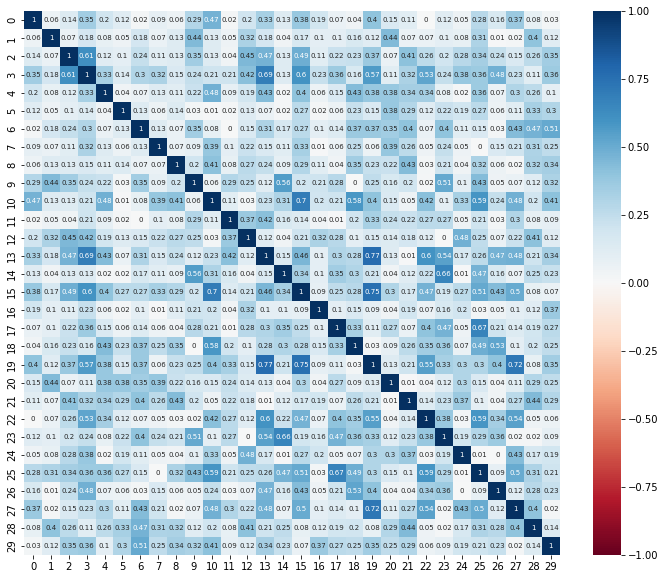

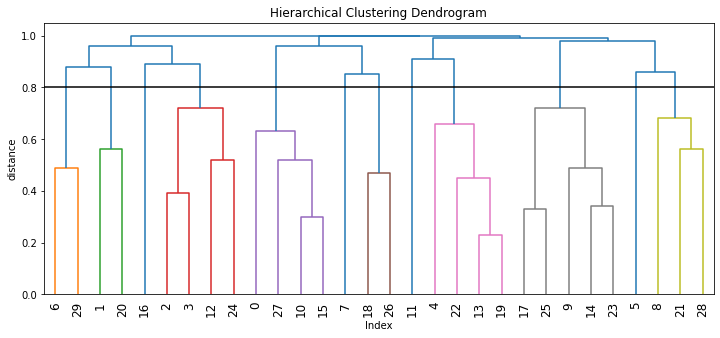

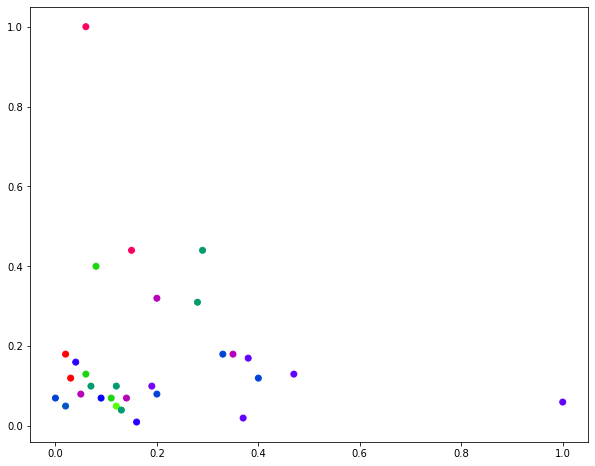

In [2]:
# this section graphs some of the results. Previous cell needs to be run before!

import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# function taken from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Index')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

X_corr = np.corrcoef(X, rowvar=False)  # spearmanr(X)[0]
X_corr = np.fabs(X_corr).round(2)

plt.figure(figsize=(12, 10))
sns.heatmap(X_corr, cmap="RdBu", annot=True, annot_kws={"size": 7}, vmin=-1, vmax=1)

plt.figure(figsize=(12, 5))
dis = 1 - X_corr
np.fill_diagonal(dis, 0, wrap=False)
dis = np.maximum(dis, dis.transpose())
Z = linkage(squareform(dis), "complete")
clusters = fcluster(Z, threshold, criterion="distance")

fancy_dendrogram(
    Z,
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d=threshold
)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X_corr[:,0], X_corr[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()